# Deep Q-Learning

In [2]:
%matplotlib notebook

from random import choice, randint, sample
from collections import deque

import numpy as np
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

/home/murthy/Envs/pyschieber/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Actions

In [3]:
def right(x, y):
    return x + 1 if x < 2 else x, y


def left(x, y):
    return x - 1 if x > 0 else x, y


def up(x, y):
    return x, y - 1 if y > 0 else y


def down(x, y):
    return x, y + 1 if y < 2 else y


actions = [left, right, up, down]

illegal_actions = [(0, 0, left), (0, 0, up), (1, 0, up), (2, 0, up), (2, 0, right), (0, 1, left),
                   (0, 2, left), (0, 2, down), (1, 2, down), (2, 2, down), (2, 2, right), (2, 1, right)]

### Reward

In [4]:
reward = {(0, 0, left): 100, (0, 0, right): 0, (0, 0, up): 100, (0, 0, down): 0,
          (0, 1, left): -1, (0, 1, right): 0, (0, 1, up): 100, (0, 1, down): 0,
          (0, 2, left): -1, (0, 2, right): 0, (0, 2, up): 0, (0, 2, down): -1,
          (1, 0, left): 100, (1, 0, right): 0, (1, 0, up): -1, (1, 0, down): 0,
          (1, 1, left): 0, (1, 1, right): 0, (1, 1, up): 0, (1, 1, down): 0,
          (1, 2, left): 0, (1, 2, right): 0, (1, 2, up): 0, (1, 2, down): -1,
          (2, 0, left): 0, (2, 0, right): -1, (2, 0, up): -1, (2, 0, down): 0,
          (2, 1, left): 0, (2, 1, right): -1, (2, 1, up): 0, (2, 1, down): 0,
          (2, 2, left): 0, (2, 2, right): -1, (2, 2, up): 0, (2, 2, down): -1, }

### Helper functions

In [5]:
def position_to_state(x, y):
    state = np.zeros(16, dtype='float32')
    state[4 * y + x] = 1.
    return np.expand_dims(state, axis=0)


def state_to_position(state):
    index = np.where(state == 1.)
    x = index % 4
    y = index / 4
    return x, y


def output_to_action(output):
    index = np.where(output == 1.)
    return actions[index]


def print_dq(model):
    for y in range(3):
        for x in range(3):
            target = model.predict(position_to_state(x, y))
            print('({0},{1}): ← {2}'.format(x, y, target[0][0]))
            print('({0},{1}): → {2}'.format(x, y, target[0][1]))
            print('({0},{1}): ↑ {2}'.format(x, y, target[0][2]))
            print('({0},{1}): ↓ {2}'.format(x, y, target[0][3]))

## Agent

In [8]:
class Agent:
    def __init__(self, gamma=0.95, exploration_rate=0.9):
        self.gamma = gamma
        self.exploration_rate = exploration_rate
        self.memory = deque([], maxlen=1000)
        self.model = self.get_model()
        self.target_model = self.get_model()
        self.nr_moves = []

    def get_model(self):
        model = Sequential()
        model.add(Dense(24, input_shape=(16,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(4, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=0.01))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        batch = sample(self.memory, 100) if len(self.memory) > 100 else self.memory
        for state, action, r, next_state, done in batch:
            target = r
            if not done:
                state = position_to_state(state[0], state[1])
                next_state = position_to_state(next_state[0], next_state[1])
                target = r + self.gamma \
                             * np.amax(self.target_model.predict(next_state)[0])
            target_values = self.model.predict(state)
            target_values[0][actions.index(action)] = target
            self.model.fit(state, target_values, epochs=1, verbose=0)
        self.target_model.set_weights(self.model.get_weights())

    def act(self, x, y):
        state = position_to_state(x, y)
        if np.random.rand() >= self.exploration_rate:
            return choice(actions)
        act_values = self.model.predict(state)
        return actions[np.argmax(act_values[0])]

    def train(self, episodes=1):
        for _ in range(episodes):
            x, y = randint(0, 2), randint(0, 2)
            move_counter = 0
            while not (x == 0 and y == 0):
                action = self.act(x, y)
                next_x, next_y = action(x, y)
                done = False if not (x == 0 and y == 0) else True
                r = reward[x, y, action]
                self.remember(state=(x, y), action=action, reward=r,
                              next_state=(next_x, next_y), done=done)
                x, y = next_x, next_y
                move_counter += 1
            self.replay()
            self.nr_moves.append(move_counter)

    def run(self, x, y):
        action_counter = 0
        self.exploration_rate = 1.1
        while not (x == 0 and y == 0):
            action = self.act(x, y)
            x, y = action(x, y)
            action_counter += 1
        return action_counter

### Run

In [9]:
agent = Agent()
agent.train(episodes=50)
for start_x, start_y in [(2, 2), (2, 1), (1, 1)]:
    print('Start:({},{}) It took {} actions to the goal.'.format(start_x, start_y, agent.run(start_x, start_y)))
    print('-' * 100)
print_dq(agent.target_model)

Start:(2,2) It took 4 actions to the goal.
----------------------------------------------------------------------------------------------------
Start:(2,1) It took 3 actions to the goal.
----------------------------------------------------------------------------------------------------
Start:(1,1) It took 2 actions to the goal.
----------------------------------------------------------------------------------------------------
(0,0): ← 327.4658203125
(0,0): → 284.09771728515625
(0,0): ↑ 317.4602966308594
(0,0): ↓ 310.7573547363281
(1,0): ← 407.7633361816406
(1,0): → 345.8309631347656
(1,0): ↑ 373.92230224609375
(1,0): ↓ 375.3101806640625
(2,0): ← 380.1492004394531
(2,0): → 320.4601745605469
(2,0): ↑ 347.7419128417969
(2,0): ↓ 346.3317565917969
(0,1): ← 393.33465576171875
(0,1): → 349.6856384277344
(0,1): ↑ 407.4975891113281
(0,1): ↓ 383.3641662597656
(1,1): ← 390.6243591308594
(1,1): → 333.37139892578125
(1,1): ↑ 376.39495849609375
(1,1): ↓ 359.57794189453125
(2,1): ← 358.935821533203

<IPython.core.display.Javascript object>


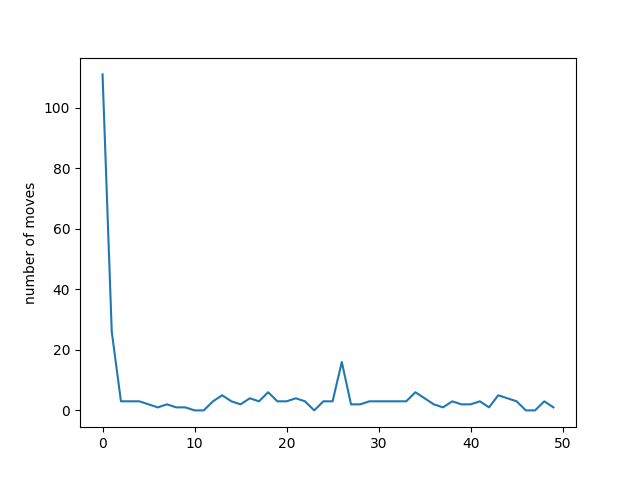

In [10]:
import matplotlib.pyplot as plt
plt.plot(agent.nr_moves, marker='o')
plt.ylabel('number of moves')
plt.show()